### 1. Read in the enriched PartB data for year 2013 & 2014

In [1]:
import pandas as pd
import numpy as np
import os 
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
parent = os.path.dirname(os.getcwd())

df = pd.read_csv(parent + '/data/year2013_2014_combined_with_labels.csv')
df.fillna(0, inplace=True)

# store the category code one-to-one mapping for Rndrng_Prvdr_Type
c_Type = df['Rndrng_Prvdr_Type'].astype('category')
codes_Type = c_Type.cat.codes
cats_Type = c_Type.cat.categories

# store the category code one-to-one mapping for Rndrng_Prvdr_Gndr
c_Gndr = df['Rndrng_Prvdr_Gndr'].astype('category')
codes_Gndr = c_Gndr.cat.codes
cats_Gndr = c_Gndr.cat.categories

# store the category code one-to-one mapping for Rndrng_Prvdr_Mdcr_Prtcptg_Ind
c_Ind = df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'].astype('category')
codes_Ind = c_Ind.cat.codes
cats_Ind = c_Ind.cat.categories

df['Rndrng_Prvdr_Type'] = codes_Type
df['Rndrng_Prvdr_Gndr'] = codes_Gndr
df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'] = codes_Ind

print(df.shape)

(1847558, 89)


### 2. Split the data to a train set (used for cross validation) and a test set (holdout)

In [2]:
# split out the holdout data by Rndrng_NPI to avoid data leakage
import random
random.seed(42)
holdout_rate = 0.1

uniq_id = df.Rndrng_NPI.unique()
holdout_set = random.sample(list(uniq_id), int(len(uniq_id)*holdout_rate))
train_set = list(set(uniq_id) - set(holdout_set))

train=df.query("`Rndrng_NPI` in @train_set")
holdout=df.query("`Rndrng_NPI` in @holdout_set")

train_X = train.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
train_y = train.Fraud_Indicator

test_X = holdout.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
test_y = holdout.Fraud_Indicator

print(train_X.shape, test_X.shape)

(1662708, 86) (184850, 86)


### 3. Function to draw the confusion matrix heatmap

In [3]:
# Create the function to visulize the confusion matrix
from sklearn.metrics import roc_auc_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(estimator, test_X, test_y):
    # Create the NumPy array for actual and predicted labels.
    actual    = test_y
    predicted = estimator.predict(test_X)
    # compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)
    # Plot the confusion matrix.
    sns.heatmap(cm,
                annot=True,
                annot_kws={'size': 14},
                fmt='d', 
                cmap='Blues',
                xticklabels=['Non-Fraud','Fraud'],
                yticklabels=['Non-Fraud','Fraud']) 
    sns.set(font_scale=1.3)
    plt.ylabel('Actual',fontsize=13)
    plt.xlabel('Prediction',fontsize=13)
    plt.title('Holdout set Confusion Matrix', fontsize=15)
    return plt.show()

### 4. Function to draw the ROC-AUC curve

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

def plot_roc_auc_curve(estimator, test_X, test_y):
    
    y_pred = estimator.predict_proba(test_X)[:, 1]
    roc_auc = roc_auc_score(test_y, y_pred)

    fpr, tpr, _ = roc_curve(test_y, y_pred)
    roc_auc_curve = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_curve)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate',fontsize=13)
    plt.ylabel('True Positive Rate',fontsize=13)
    plt.title('Holdout set Receiver Operating Characteristic (ROC)', fontsize=15)
    plt.legend(loc="lower right")
    return plt.show()

### 5. Function to read in models in cloudpickle format, apply holdout set to get the plot

In [6]:
import glob
import cloudpickle
import re
def plot_eval_holdoutset(pat):
    path = parent + '/models'
    cloudpickle_files = glob.glob(os.path.join(path, f"{pat}*.cloudpickle"))
    cloudpickle_files.sort()
    eval_y = test_y
    eval_X = test_X
    global all_pipe_fitted
    all_pipe_fitted = []
    for cpk in cloudpickle_files:
        if cpk.split('/')[-1].split('.')[0].split('_')[0] == 'rf':
            model_lab = 'Random Forest:'
        elif cpk.split('/')[-1].split('.')[0].split('_')[0] == 'xgb':
            model_lab = 'XGBoost:'
        elif cpk.split('/')[-1].split('.')[0].split('_')[0] == 'lgbm':
            model_lab = 'Light GBM:'
        if cpk.split('/')[-1].split('.')[0][-1] == '1':
            dsample_rat = '10:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '2':
            dsample_rat = '4:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '3':
            dsample_rat = '2:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '4':
            dsample_rat = '1:1'

        cpkpipe = cloudpickle.load(open(cpk, 'rb'))
        y_pred = cpkpipe.predict(eval_X)
        all_pipe_fitted.append(cpkpipe)
        eval_score0 = roc_auc_score(train_y, cpkpipe.predict_proba(train_X)[:, 1])
        eval_score = roc_auc_score(eval_y, cpkpipe.predict_proba(eval_X)[:, 1])
        plot_roc_auc_curve(cpkpipe, eval_X, eval_y)
        
        print('     ' + model_lab, 'downsampling the class ratio to', dsample_rat, 
#               '\n - Training set roc-auc evaluation score: ', round(eval_score0, 4),
              '\n      Holdout set roc-auc evaluation score: ', round(eval_score, 4))
        plot_confusion_matrix(cpkpipe, eval_X, eval_y)

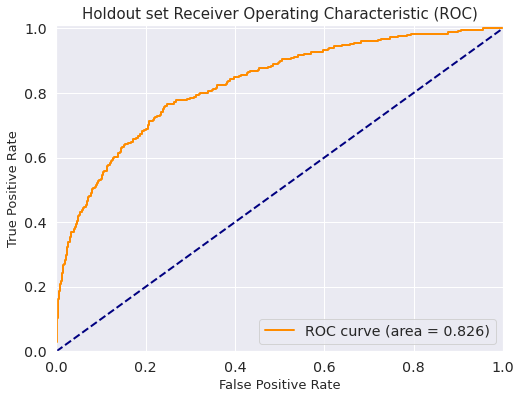

     Light GBM: downsampling the class ratio to 10:1 
      Holdout set roc-auc evaluation score:  0.8264


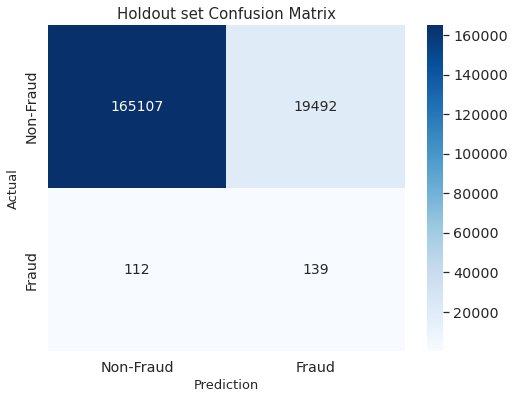

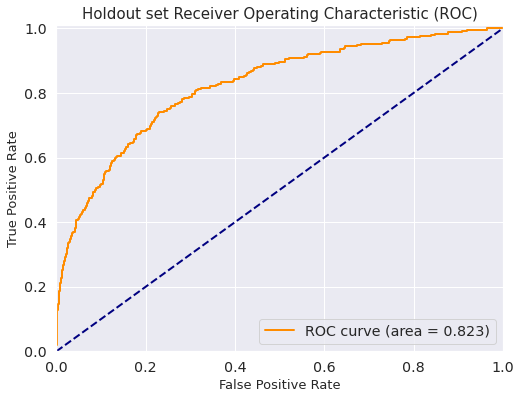

     Light GBM: downsampling the class ratio to 4:1 
      Holdout set roc-auc evaluation score:  0.8229


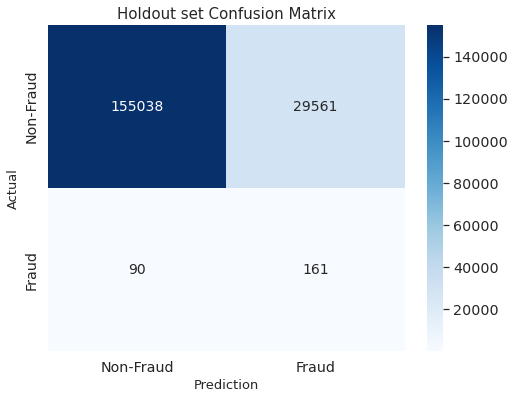

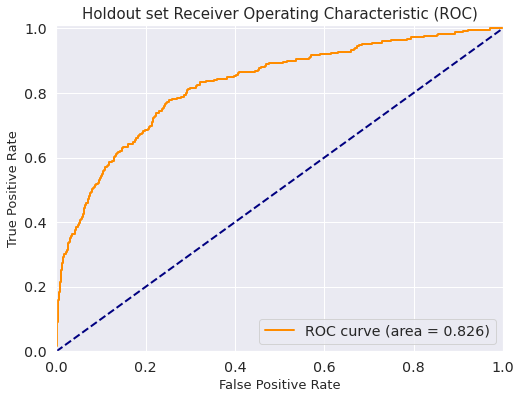

     Light GBM: downsampling the class ratio to 2:1 
      Holdout set roc-auc evaluation score:  0.8255


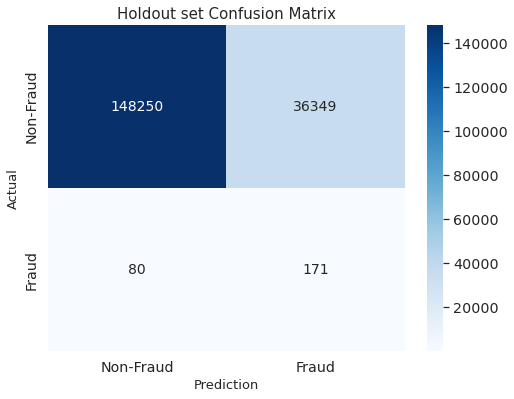

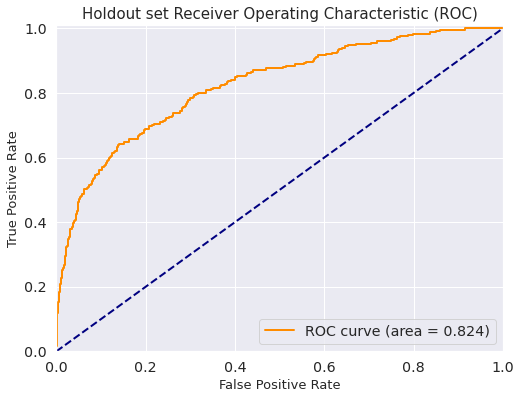

     Light GBM: downsampling the class ratio to 1:1 
      Holdout set roc-auc evaluation score:  0.8242


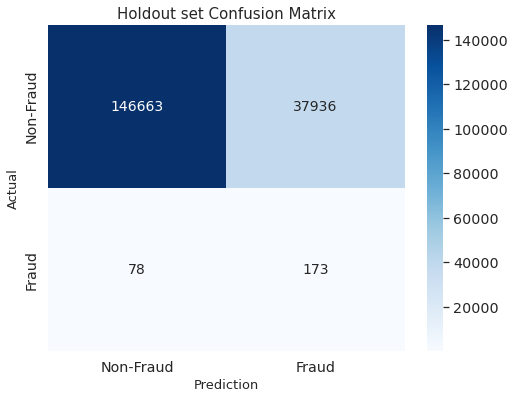

In [8]:
# LightGBM
plot_eval_holdoutset("lgbm_pipe")

### 6. SHAP - Visualize the feature importance of each feature in the model
code source https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

In [7]:
#1) Setting up the SHAP Explainer
import shap
explainer = shap.Explainer(all_pipe_fitted[0].named_steps['clf'])
shap_values = explainer.shap_values(test_X)

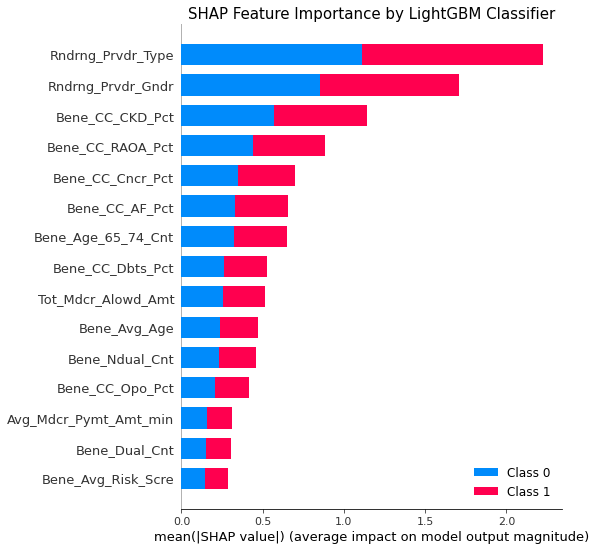

In [8]:
# 2) Summary Plot - Visualize the feature importance of each feature in the model
shap.summary_plot(shap_values, test_X, max_display=15, plot_type="bar", show=False)
plt.title("SHAP Feature Importance by LightGBM Classifier", fontsize=15)
plt.show()

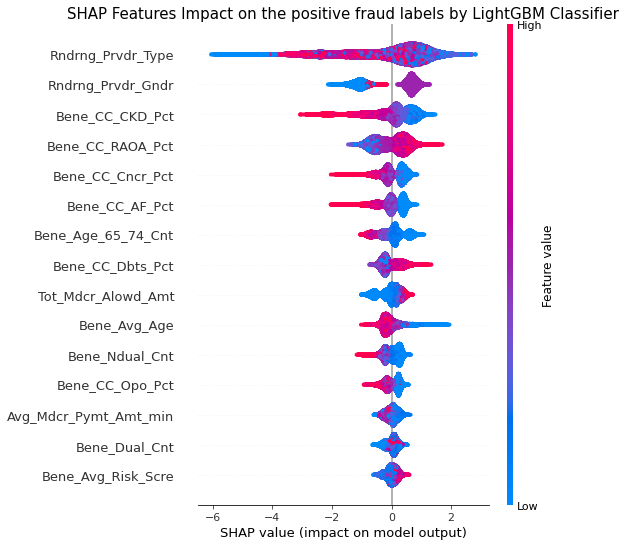

In [33]:
shap.summary_plot(shap_values[1], test_X, max_display=15, show=False)
plt.title("SHAP Features Impact on the positive fraud labels by LightGBM Classifier", fontsize=15)
plt.show()

In [29]:
print(cats_Gndr[0])
print(cats_Gndr[1])
print(cats_Gndr[2])

F
M
U


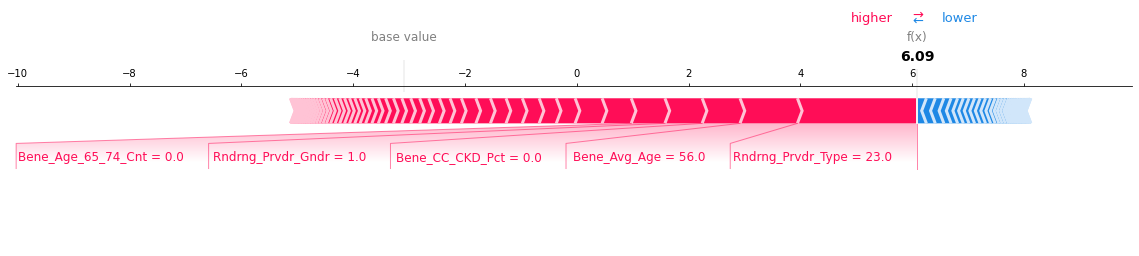

Family Practice
M


In [30]:
# 3) Force Plot - Visualize the what fators contributes most for labeling a fraudulent provider by example
# how features contributed to the model’s prediction for a specific observation
shap.plots.force(explainer.expected_value[1], shap_values[1][6, :], test_X.iloc[6, :], matplotlib = True)

print(cats_Type[23])
print(cats_Gndr[1])

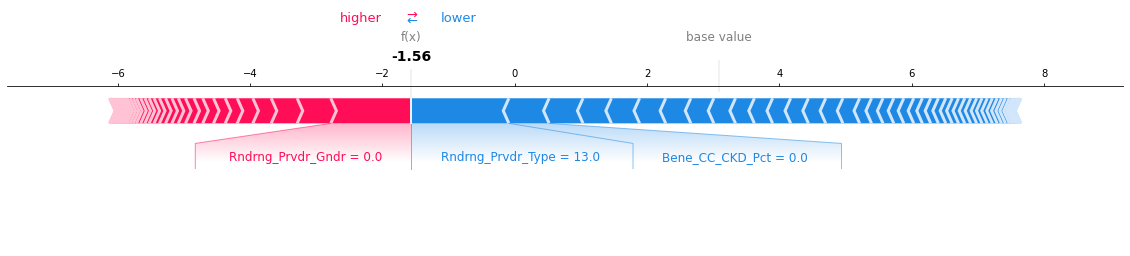

In [31]:
shap.plots.force(explainer.expected_value[0], shap_values[0][1001,:], test_X.iloc[1001, :], matplotlib = True)